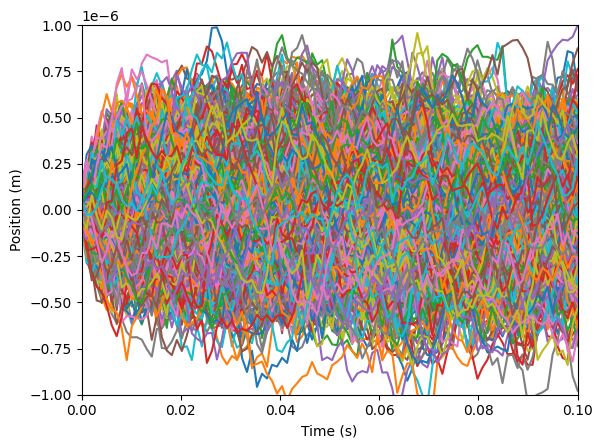

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

k_B = 1.38e-23
T0 = 200 # Initial temperature
T = 5000
k = 1e-6
gamma = 2e-8
dt = 0.001
n = 1000
time_steps = 100
time = np.linspace(0, 0.1, time_steps)
x_0 = np.random.normal(0, np.sqrt(k_B * T0 / k), n)

# Function to calculate trajectory
def trajectory(x_0, time, k, gamma, k_B, T, dt):
    positions = [x_0]
    for t in time[1:]:
        x_i_minus_1 = positions[-1]
        x_i = (1 - (k / gamma) * dt) * x_i_minus_1 + np.sqrt(2 * k_B * T * dt / gamma) * np.random.normal(0, 1)
        positions.append(x_i)
    return np.array(positions)
trajectories = np.array([trajectory(pos, time, k, gamma, k_B, T, dt) for pos in x_0])


for i in range(n):
    plt.plot(time, trajectories[i])
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.xlim(0, 0.1)
plt.ylim(-1e-6, 1e-6)
plt.show()

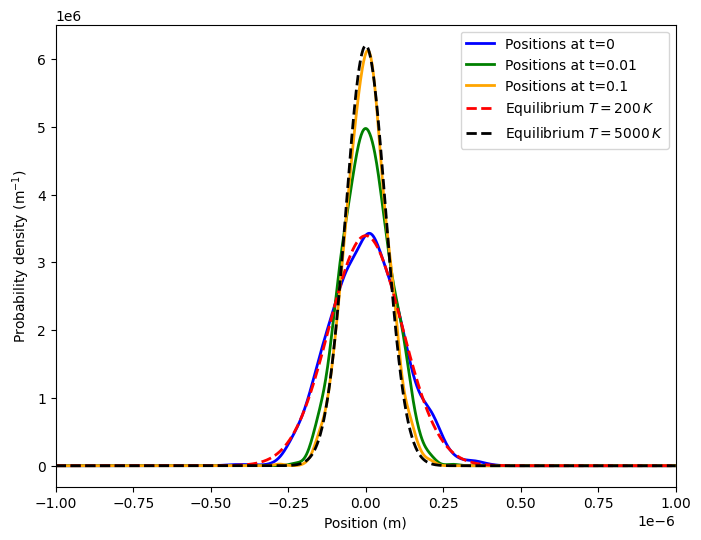

In [ ]:

def boltzmann_distribution(x, k, T, k_B):
    return np.sqrt(k / (2 * np.pi * k_B * T)) * np.exp(-k * x**2 / (2 * k_B * T))


x_vals = np.linspace(-1e-6, 1e-6, 1000)
P_eq_1000K = boltzmann_distribution(x_vals, k, 1000, k_B)
P_eq_300K = boltzmann_distribution(x_vals, k, 300, k_B)


time_indices = [0, int(time_steps / 6), time_steps - 1]
colors = ['blue', 'green', 'orange', 'purple']
labels = ['t=0', 't=0.01', 't=0.1']
plt.figure(figsize=(8, 6))

# Plot KDE for particle positions at different time steps
for idx, t_idx in enumerate(time_indices):
    positions_at_t = trajectories[t_idx, :]
    kde = gaussian_kde(positions_at_t)
    plt.plot(x_vals, kde(x_vals), color=colors[idx], label=f'Positions at {labels[idx]}', linewidth=2)


plt.plot(x_vals, P_eq_1000K, 'r--', label=r'Equilibrium $T=200\,K$', linewidth=2)
plt.plot(x_vals, P_eq_300K, 'k--', label=r'Equilibrium $T=5000\,K$', linewidth=2)
plt.xlabel('Position (m)')
plt.ylabel('Probability density ($\mathrm{m}^{-1}$)')
plt.legend()
plt.xlim(-1e-6, 1e-6)
plt.show()

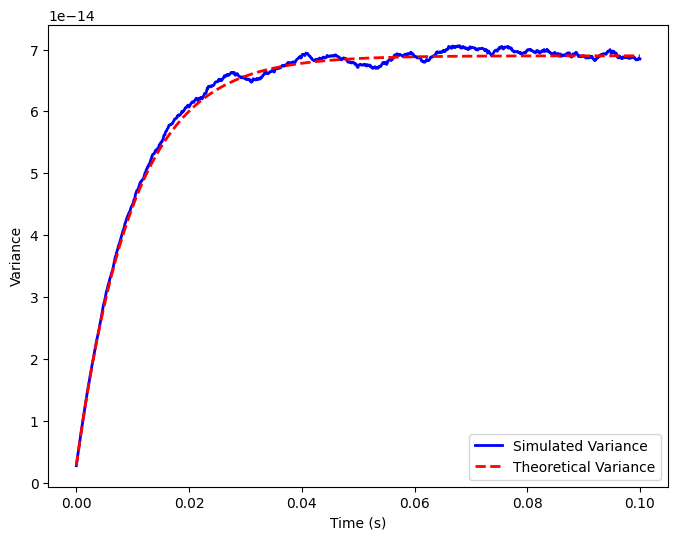

In [ ]:
def theoretical_variance(t, T0, T, k, gamma, k_B):
    return (k_B * T0 * np.exp(-2 * k * t / gamma) + k_B * T * (1 - np.exp(-2 * k * t / gamma))) / k

variance_theoretical = theoretical_variance(time,T0, T, k, gamma, k_B)
variance_simulated = np.var(trajectories, axis=1)
plt.figure(figsize=(8, 6))
plt.plot(time, variance_simulated, label='Simulated Variance', color='blue', linewidth=2)
plt.plot(time, variance_theoretical, '--', label='Theoretical Variance', color='red', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Variance')
plt.legend()
plt.show()

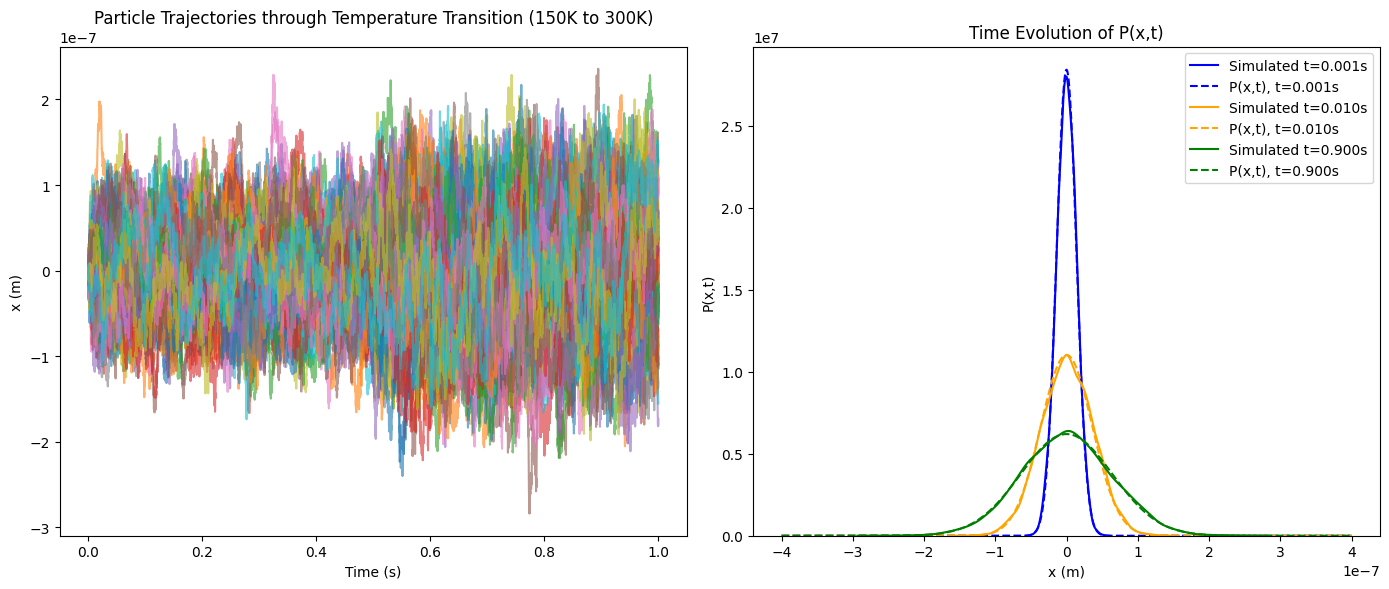

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
dt = 0.0001
imax = 10000
jmax = 10000
kB = 1.38e-23
gamma = 2e-8
k = 1e-6

def simulate():
    x = np.zeros((imax, jmax))
    variances_sim = np.zeros(imax)
    T_target = 150

    for i in range(1, imax):
        f = -k * x[i - 1, :] / gamma


        if i < int(imax / 2):
            T_target = 150
        else:
            T_target = 300  #  switch to 300K

        # Update the positions using Langevin equation:
        x[i, :] = x[i - 1, :] + dt * f + np.sqrt(2 * kB * T_target * dt / gamma) * np.random.randn(jmax)

        # Calculate the variance of the positions at time step i
        variances_sim[i] = np.var(x[i, :])

    return x, variances_sim

# Updated theoretical time-dependent probability distribution
def P_xt(x, t, x0, T, k, kB, gamma):
    temp_term = kB * T * (1 - np.exp(-2 * k * t / gamma))
    prefactor = np.sqrt(k / (2 * np.pi * temp_term))
    exponent = -k * (x - x0 * np.exp(-k * t / gamma)) ** 2 / (2 * temp_term)
    return prefactor * np.exp(exponent)

# Theoretical variance formula
def theoretical_variance(t, T, k, kB, gamma):
    return (kB * T / k) * (1 - np.exp(-2 * k * t / gamma))


x, variances_sim = simulate()

time = np.linspace(0, imax * dt, imax)

variances_theory = np.zeros(imax)
for i in range(imax):
    T_current = 150 if time[i] < 0.5 * max(time) else 300
    variances_theory[i] = theoretical_variance(time[i], T_current, k, kB, gamma)

# Define the time points for comparison
time_points = [0.001, 0.01, 0.9]  # Times in seconds
t_indices = [int(tp / dt) for tp in time_points]

x_range = np.linspace(-4e-7, 4e-7, 1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
for j in range(100):
    ax1.plot(time, x[:, j], alpha=0.6)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('x (m)')
ax1.set_title('Particle Trajectories through Temperature Transition (150K to 300K)')


colors = ['blue', 'orange', 'green']
for i, t_index in enumerate(t_indices):
    t = time_points[i]  # Current time
    xi = x[t_index, :]
    T_target = 150 if t < 0.05 else 300

    time_dependent_dist = P_xt(x_range, t, 0, T_target, k, kB, gamma)

    sns.kdeplot(xi, label=f'Simulated t={t:.3f}s', color=colors[i], ax=ax2)
    ax2.plot(x_range, time_dependent_dist, label=f'P(x,t), t={t:.3f}s', color=colors[i], linestyle='--')

ax2.set_xlabel('x (m)')
ax2.set_ylabel('P(x,t)')
ax2.set_title('Time Evolution of P(x,t)')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


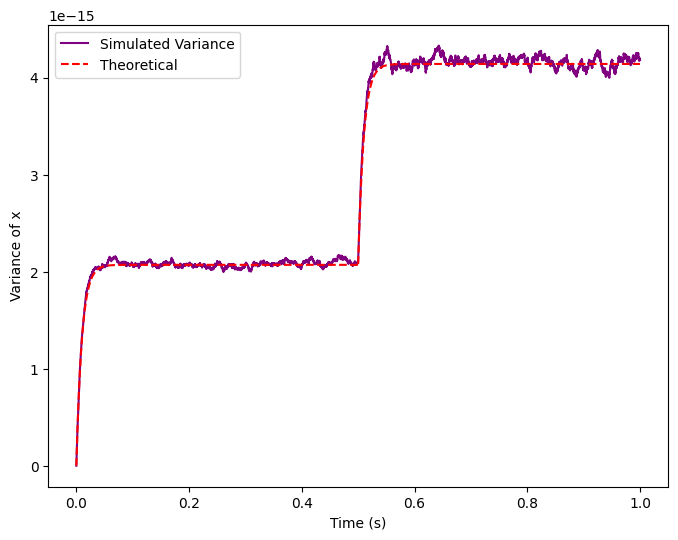

In [7]:

def theoretical_variance_region1(t, T, k, kB, gamma):
    return (kB * T / k) * (1 - np.exp(-2 * k * t / gamma))

def theoretical_variance_region2(t, T0, T, k, kB, gamma):
    return (kB * T / k) + (kB * (T0 - T) / k) * np.exp(-2 * k * t / gamma)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time, variances_sim, color='purple', label='Simulated Variance')
variances_theory_150K = [theoretical_variance_region1(t, 150, k, kB, gamma) for t in time[:int(imax/2)]]
ax.plot(time[:int(imax/2)], variances_theory_150K, color='red', linestyle='--')
variances_theory_transition = [
    theoretical_variance_region2(t - 0.5 * max(time), 150, 300, k, kB, gamma)
    for t in time[int(imax/2):]
]
ax.plot(time[int(imax/2):], variances_theory_transition, color='red', linestyle='--', label='Theoretical')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Variance of x')
ax.legend()

plt.show()
